# Описание задачи и имеющихся данных


Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

# Импорт необходимых библиотек

In [1]:
!pip install -q spacy

DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import numpy as np
import pandas as pd

import os


#!pip -q install --upgrade fschat accelerate autoawq vllm
import torch


import transformers as ppb # pytorch transformers
import re
import random


#!pip import torchvision.models as models

#!pip resnet = models.resnet18(pretrained=True) #загружаем претренированную модель



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from tqdm import notebook
from sklearn.metrics import f1_score

from sklearn.model_selection import GroupShuffleSplit

#from transformers import AutoTokenizer, AutoModel

from sklearn.utils import shuffle

from sklearn.dummy import DummyRegressor




import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
import spacy




from sklearn.preprocessing import StandardScaler


import torch.nn as nn
import copy

import matplotlib.pyplot as plt

import random
from math import ceil

from sklearn.metrics import mean_squared_error as mse


from PIL import Image

import warnings
warnings.filterwarnings('ignore')

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to /Users/alexander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 873.9 kB/s eta 0:00:0000:0100:01
DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 929.0 kB/s eta 0:00:0000:0100:02


DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

## Исследование

Пути для загрузки данных:

In [3]:
DATA_PATH = 'to_upload/'
#DATA_PATH = ''

### Тренировочные данные

In [4]:
train_dataset = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

In [5]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


Пропусков нет

In [6]:
train_dataset.duplicated().sum()

0

Дубликатов нет

### Тестовые данные

In [7]:
test_queries = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), index_col=[0], sep='|')
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


Пропусков нет

In [8]:
test_queries.duplicated().sum()

0

Дубликатов нет

In [9]:
test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


Пропусков нет

In [10]:
test_images.duplicated().sum()

0

Дубликатов нет

Ниже требуется рассмотреть оценки толпы и экспертов соответстия описаний изображениям. Во всех случаях нам требуется по нескольким оценкам составить итоговую. Назовём её агрегирвоанной.

### Оценки, полученные краудсорсингом

In [11]:
CrowdAnnotations = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t')
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1056338697_4f7d7ce270.jpg    47829 non-null  object 
 1   1056338697_4f7d7ce270.jpg#2  47829 non-null  object 
 2   1                            47829 non-null  float64
 3   3                            47829 non-null  int64  
 4   0                            47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [12]:
CrowdAnnotations.rename(columns={'1056338697_4f7d7ce270.jpg': 'image',\
                                 '1056338697_4f7d7ce270.jpg#2': 'query_id',\
                                 '1': 'frac_positive',\
                                 '3': 'positive',\
                                 '0': 'negative'}, inplace=True)
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          47829 non-null  object 
 1   query_id       47829 non-null  object 
 2   frac_positive  47829 non-null  float64
 3   positive       47829 non-null  int64  
 4   negative       47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [13]:
CrowdAnnotations.head()

image                     query_id  frac_positive  \
0  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2            0.0   
1  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2            0.0   
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2            0.0   
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2            0.0   
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2            0.0   

   positive  negative  
0         0         3  
1         0         3  
2         0         3  
3         0         3  
4         0         3

Пропусков нет. Столбцы переименовали:

- `frac_positive` -- процент проголосовавших за то, что описание соответствует изображению

- `positive` -- количество человек, подтвердивших, что описание соответствует изображению

- `negative` -- количество человек, подтвердивших, что описание не соответствует изображению

В качестве агрегированной оценки толпы возьмём `frac_positive`. Лишние столбцы уберём:

In [14]:
CrowdAnnotations['crowd_frac_positive'] = CrowdAnnotations.frac_positive
CrowdAnnotations.drop(['frac_positive', 'positive', 'negative'], axis=1, inplace=True)
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                47829 non-null  object 
 1   query_id             47829 non-null  object 
 2   crowd_frac_positive  47829 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


### Оценки экспертов

In [15]:
ExpertAnnotations = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t')
ExpertAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   1056338697_4f7d7ce270.jpg    5821 non-null   object
 1   2549968784_39bfbe44f9.jpg#2  5821 non-null   object
 2   1                            5821 non-null   int64 
 3   1.1                          5821 non-null   int64 
 4   1.2                          5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [16]:
ExpertAnnotations.rename(columns={'1056338697_4f7d7ce270.jpg': 'image',\
                                 '2549968784_39bfbe44f9.jpg#2': 'query_id',\
                                 '1': 'first_exp',\
                                 '1.1': 'second_exp',\
                                 '1.2': 'third_exp'}, inplace=True)
ExpertAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5821 non-null   object
 1   query_id    5821 non-null   object
 2   first_exp   5821 non-null   int64 
 3   second_exp  5821 non-null   int64 
 4   third_exp   5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [17]:
ExpertAnnotations.head()

image                     query_id  first_exp  \
0  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2          1   
1  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2          1   
2  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2          1   
3  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2          1   
4  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2          1   

   second_exp  third_exp  
0           1          2  
1           1          2  
2           2          2  
3           1          2  
4           1          1

Пропусков нет. Столбцы переименовали:

- `first_exp` -- оценка первого эксперта

- `second_exp` -- оценка второго эксперта

- `third_exp` -- оценка третьего эксперта

Пропусков нет

In [18]:
ExpertAnnotations.duplicated().sum()

0

Дубликатов тоже нет

## Предобработка данных

Напишем функцию, для переведения оценок экспертов в диапазон от 0 до 1

In [19]:
def exp_agg(x):
    return (x - 1)/3

In [20]:
ExpertAnnotations[['first_exp', 'second_exp', 'third_exp']] = \
ExpertAnnotations[['first_exp', 'second_exp', 'third_exp']].apply(lambda x: exp_agg(x))
ExpertAnnotations.sample(3)

image                     query_id  first_exp  \
2775  3024172109_a10198e1dd.jpg  3729525173_7f984ed776.jpg#2   0.000000   
4658  3585598356_8ce815bbb9.jpg  1282392036_5a0328eb86.jpg#2   0.333333   
2597   293879742_5fe0ffd894.jpg  2926233397_71e617f3a3.jpg#2   0.000000   

      second_exp  third_exp  
2775    0.000000   0.000000  
4658    0.666667   0.666667  
2597    0.333333   0.333333

В качестве агрегированной оценки возьмём среднее

In [21]:
ExpertAnnotations['exp_frac_positive'] = (ExpertAnnotations.first_exp + ExpertAnnotations.second_exp\
                                         + ExpertAnnotations.third_exp)/3
ExpertAnnotations.sample(3)

image                     query_id  first_exp  \
5691   757046028_ff5999f91b.jpg  3589367895_5d3729e3ea.jpg#2   0.000000   
1742  2559503010_84f20b3bc9.jpg  2061354254_faa5bd294b.jpg#2   0.000000   
4840  3651971126_309e6a5e22.jpg  3259002340_707ce96858.jpg#2   0.333333   

      second_exp  third_exp  exp_frac_positive  
5691    0.000000   0.333333           0.111111  
1742    0.000000   0.000000           0.000000  
4840    0.333333   0.333333           0.333333

Уберём лишние столбцы:

In [22]:
ExpertAnnotations.drop(['first_exp', 'second_exp', 'third_exp'], axis=1, inplace=True)

ExpertAnnotations.sample(3)

image                     query_id  \
3002  3107513635_fe8a21f148.jpg  3425835357_204e620a66.jpg#2   
4964   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
566   1773928579_5664a810dc.jpg  2813992915_f732cf8539.jpg#2   

      exp_frac_positive  
3002           0.222222  
4964           0.000000  
566            0.111111

Будем считать, что изображение можно считать соответствующим описанию, если процент больше либо равен 75, то есть, если эксперты суммарно дали оценку не меньше 9.

Требуется понять, как по агрегированным оценкам толпы и экспертов сделать финальную итоговую оценку.

Мы попробуем сумировать две агрегированные оценки с некоторыми весами, чтобы в итоге получить финальный процент соответствия

Попробуем взять веса в соответсвии с процентом корреляции одной оценки относительно другой.  

Для описаний, у которых нет либо оценки экспертов, либо оценки толпы, мы оставим ту оценку, которая есть в одном из случаев. Если не хватает обеих оценок, то такую строку исключим.

Объединим две таблицы

In [23]:
df = pd.merge(CrowdAnnotations, ExpertAnnotations, how='outer', on=['image', 'query_id'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51322 entries, 0 to 51321
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                51322 non-null  object 
 1   query_id             51322 non-null  object 
 2   crowd_frac_positive  47829 non-null  float64
 3   exp_frac_positive    5821 non-null   float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


Экспертных оценок весьма мало

Фото, для которых нет оценок одного из типов, нет:

In [25]:
df[df.crowd_frac_positive.isna() & df.exp_frac_positive.isna()]

Empty DataFrame
Columns: [image, query_id, crowd_frac_positive, exp_frac_positive]
Index: []

Корреляция:

In [26]:
df[['crowd_frac_positive', 'exp_frac_positive']].corr()

crowd_frac_positive  exp_frac_positive
crowd_frac_positive             1.000000           0.790807
exp_frac_positive               0.790807           1.000000

Корреляция есть, но не 100%. Если считать, что мы стартуем с того, что веса для оценок эскспертов и толпы были одинаковы и равны 0.5, то таблица велит нам отнять примерно 20% веры в оценки толпы. Тогда положим вес оценки толпы равным 0.2, а вес оценки экспертов 0.8.  

Функция для проставления финальной оценки:

In [27]:
def max_exp_global(x):
    if x.isna().exp_frac_positive ==True:
        return x.crowd_frac_positive
    else:
        if x.isna().crowd_frac_positive == True:
            return x.exp_frac_positive
        else:
            return 0.2 * x.crowd_frac_positive + 0.8 * x.exp_frac_positive

In [28]:
df['final_score'] = df[['crowd_frac_positive', 'exp_frac_positive']]\
.apply(max_exp_global, axis=1)
df[~df.crowd_frac_positive.isna() & ~df.exp_frac_positive.isna()].sample(10)

image                     query_id  \
42581   424416723_19c56cb365.jpg  1554713437_61b64527dd.jpg#2   
35410  3497224764_6e17544e0d.jpg   421322723_3470543368.jpg#2   
43366   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
23447  3051384385_c5c850c1f8.jpg  2228022180_9597b2a458.jpg#2   
45700   539751252_2bd88c456b.jpg  3245460937_2710a82709.jpg#2   
1247    127490019_7c5c08cb11.jpg   700884207_d3ec546494.jpg#2   
7590   2206960564_325ed0c7ae.jpg  3514019869_7de4ece2a5.jpg#2   
16200  2662845514_8620aaee96.jpg  3222055946_45f7293bb2.jpg#2   
35453  3498327617_d2e3db3ee3.jpg  3070011270_390e597783.jpg#2   
42526   421730441_6b2267fd31.jpg   421730441_6b2267fd31.jpg#2   

       crowd_frac_positive  exp_frac_positive  final_score  
42581             0.000000           0.333333     0.266667  
35410             0.000000           0.222222     0.177778  
43366             0.000000           0.333333     0.266667  
23447             0.000000           0.333333     0.266667  
45700             0.000000           0.333333     0.266667  
1247              0.000000           0.111111     0.088889  
7590              0.333333           0.555556     0.511111  
16200             0.000000           0.000000     0.000000  
35453             1.000000           0.888889     0.911111  
42526             1.000000           1.000000     1.000000

Уберем оценки экспертов и толпы

In [29]:
df.drop(['crowd_frac_positive', 'exp_frac_positive'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51322 entries, 0 to 51321
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51322 non-null  object 
 1   query_id     51322 non-null  object 
 2   final_score  51322 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


Таблица с оценками готова. Осталось присоединить их к картинкам

In [30]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [31]:
data = pd.merge(df, train_dataset, how='left', on=['image', 'query_id']).drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51322 entries, 0 to 51321
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51322 non-null  object 
 1   query_id     51322 non-null  object 
 2   final_score  51322 non-null  float64
 3   query_text   5822 non-null   object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


Большое число пропусков наблюдаем в графе с текстом описания. Судя по логике построения, тексты описания жёстко связаны с `query_id`. Попробуем проверить, может, некоторые из пропусков удастся восстановить.

Информация ниже показывает, что есть большое пересечение по `query_id` среди тех, у кого `query_text` пуст и непуст

In [32]:
data.query_id.nunique()

1000

In [33]:
data[data.query_text.notna()].query_id.nunique()

977

In [34]:
data[data.query_text.isna()].query_id.nunique()

1000

Похоже, что данные не присоединились из-за того, что мы соединяли таблицы по двум ключам `image` и `query_id`. Забьём поставшиеся пропуски слиянием только по строке `query_id`:

Сначала там, где есть пересечение по 2:

In [35]:
ddf1 = data[data.query_text.notna()]
ddf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 11 to 51321
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   final_score  5822 non-null   float64
 3   query_text   5822 non-null   object 
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


In [36]:
ddf2 = pd.merge(data[data.query_text.isna()].drop(['query_text'], axis=1), train_dataset.drop(['image'], axis=1), how='left',\
                on=['query_id']).drop_duplicates()
ddf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45500 entries, 0 to 268676
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        45500 non-null  object 
 1   query_id     45500 non-null  object 
 2   final_score  45500 non-null  float64
 3   query_text   44391 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


Обьединим и удалим записи, где `query_text` пуст

In [37]:
data = pd.concat([ddf1, ddf2], ignore_index=True).dropna(subset=['query_text'])\
.drop_duplicates(ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50213 non-null  object 
 1   query_id     50213 non-null  object 
 2   final_score  50213 non-null  float64
 3   query_text   50213 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


# Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Составим список слов, при встрече которых придётся сделать исключение:

In [38]:
kinder = {'baby',
'boy',
'child',
'kid',
'kindergarten',
'daughter',
'newborn',
'girl',
'infant',
'toddler',
'son',
'daughter',
'teenager',
'youngster',
'schoolboy',
'schoolgirl',
'school',
'pupil',
'youth',
'bairn',
'juvenile',
'junior',
'teen',
'lad',
'lass',
'tot'}

Для удаления лишнего и обучения требуется предобработать текст. Функция для обработки

In [39]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [40]:
def clean_text_v1(text):

  text = re.sub(re.compile('<.*?>'), '', text)
  text = re.sub('[^A-Za-z0-9]+', ' ', text)

  text = text.lower()

  tokens = nltk.word_tokenize(text)

  text = [word for word in tokens if word not in stop_words]

  text = [lemmatizer.lemmatize(word) for word in text]

  text = ' '.join(text)

  return text

Пример работы функции:

In [41]:
clean_text_v1(data.loc[0, 'query_text'])

'young child wearing blue goggles sitting float pool'

In [42]:
data_1 = data.copy()
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50213 non-null  object 
 1   query_id     50213 non-null  object 
 2   final_score  50213 non-null  float64
 3   query_text   50213 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


In [43]:
data.query_text = data.query_text.apply(lambda x: clean_text_v1(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50213 non-null  object 
 1   query_id     50213 non-null  object 
 2   final_score  50213 non-null  float64
 3   query_text   50213 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


Теперь напишем функцию для выявления опасных картинок по тексту. Функция создаст новый столбец из 0 и 1. Где 1, если текст и соответствующая картинка подлежат удалению. И 0, если нет.

In [44]:
def kinder_check(text):
    if len(kinder.intersection(set(text.split(' ')))) == 0:
        return 0
    else:
        return 1

In [45]:
data['child_query_id_check'] = data.query_text.apply(lambda x: kinder_check(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 50213 non-null  object 
 1   query_id              50213 non-null  object 
 2   final_score           50213 non-null  float64
 3   query_text            50213 non-null  object 
 4   child_query_id_check  50213 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


Оставим записи, которые потенциально без детей, и уберём ненужный столбце с маркером. Напрямую делать это опасно: ведь у фото с детьми может быть другое описание, которое стоп-слов не содержало. Требуется вычленить ещё и id соответствующих фото. Ну и удалить фото. И лучше сделать это с помощью `query_id`, ведь там есть информация о id фото. Требуется отбросить 2 последних символа.

Список плохих фото:

In [46]:
bad_photo = data[data.child_query_id_check == 1].query_id.apply(lambda x: x[0:-2]).unique()
len(bad_photo)

293

Функция, помечающая плохие фото

In [47]:
def photo_check(x):
    if x in bad_photo:
        return 1
    else:
        return 0

In [48]:
data['child_image_check'] = data.image.apply(lambda x: photo_check(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50213 entries, 0 to 50212
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 50213 non-null  object 
 1   query_id              50213 non-null  object 
 2   final_score           50213 non-null  float64
 3   query_text            50213 non-null  object 
 4   child_query_id_check  50213 non-null  int64  
 5   child_image_check     50213 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 2.3+ MB


Чистка data и data_1. Предвариательно добавим в data_1 столбцы с метками.

In [49]:
data_1['child_query_id_check'] = data['child_query_id_check']
data_1['child_image_check'] = data['child_image_check']

Финальная чистка

In [50]:
data = data[(data.child_query_id_check == 0) & (data.child_image_check == 0)]\
.drop(['child_query_id_check', 'child_image_check'], axis=1).drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28848 entries, 2 to 50212
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        28848 non-null  object 
 1   query_id     28848 non-null  object 
 2   final_score  28848 non-null  float64
 3   query_text   28848 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [51]:
data_1 = data_1[(data_1.child_query_id_check == 0) & (data_1.child_image_check == 0)]\
.drop(['child_query_id_check', 'child_image_check'], axis=1).drop_duplicates()
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28848 entries, 2 to 50212
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        28848 non-null  object 
 1   query_id     28848 non-null  object 
 2   final_score  28848 non-null  float64
 3   query_text   28848 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


# Векторизация изображений

Перейдём к векторизации изображений.

Применим свёрточные сети: они позволяют "выделить" главные компоненты изображений. Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [52]:
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=os.path.join(DATA_PATH, 'train_images/'),
        x_col='image',
        y_col='final_score',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        shuffle=False)

Found 28848 validated image filenames.


In [53]:
backbone = ResNet50(
input_shape=(224, 224, 3),
weights='imagenet',
include_top=False)


model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [54]:
image_embeddings = model.predict(gen_flow)

902/902 ━━━━━━━━━━━━━━━━━━━━ 893s 990ms/step


# Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

In [55]:
def clean_text_v2(text):
    return ' '.join((re.sub(r'[^a-zA-Z.,]', ' ', text)).split())

In [56]:
data_1.query_text = data_1.query_text.apply(lambda x: clean_text_v2(x))

In [57]:
nlp = spacy.load("en_core_web_md")

In [58]:
%%time

embeddings = []

for text in data_1.query_text:
   embeddings.append(nlp(clean_text_v1(text)).vector)

text_embeddings = np.array(embeddings)

CPU times: user 1min 17s, sys: 366 ms, total: 1min 17s
Wall time: 1min 18s


In [59]:
text_embeddings.shape

(28848, 300)

# Объединение векторов

Соединим признаки, отделим таргет:

In [60]:
features = np.concatenate((image_embeddings, text_embeddings), axis=1)
target = np.array(data.final_score)

print(features.shape)
print(target.shape)

(28848, 2348)
(28848,)


# Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом `GroupShuffleSplit` из библиотеки sklearn.model_selection.

## Выбор метрики

Перед нами задача регрессии, и нам хотелось бы, чтобы ответы модели минимально отклонялись от истинных. Используем метрику RMSE (искажение масштаба не должно быть, так что берём корень из квадратического отклонения).

Разделим выборки в соответствии с тем, что указано выше:

In [61]:
groups = data.image

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=12345)
train_indices, test_indices = next(gss.split(X=features, y=target, groups=groups))


features_train, features_valid = features[train_indices], features[test_indices]
target_train, target_valid = target[train_indices], target[test_indices]

Масштабируем данные:

In [62]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

Вопроизводимость результатов:

In [63]:
random.seed(42)
np.random.seed(6996)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

Попробуем Dummy Regeressor:

In [64]:
dummy_regressor = DummyRegressor(strategy= 'median')

dummy_regressor.fit(features_train, target_train)

dummy_predictions = dummy_regressor.predict(features_valid)

rmse_dummy = np.sqrt(mean_squared_error(target_valid, dummy_predictions))

rmse_dummy

0.25444899553428646

Попробуем Линейную регрессию с L2-регуляризацией

In [65]:
model_regL2 = Ridge()
model_regL2.fit(features_train, target_train)

regL2_predict = model_regL2.predict(features_valid)
rmse_regL2 = np.sqrt(mean_squared_error(target_valid, regL2_predict))
rmse_regL2

1.0072015170290087

Попробуем Линейную регрессию с L1-регуляризацией

In [66]:
model_regL1 = Lasso()
model_regL1.fit(features_train, target_train)

regL1_predict = model_regL1.predict(features_valid)
rmse_regL1 = np.sqrt(mean_squared_error(target_valid, regL1_predict))
rmse_regL1

0.23437404435529693

Попробуем нейросеть:

Готовим тензоры по обучающей и валидационной выборке:

In [67]:
X_train = torch.FloatTensor(features_train)
X_test = torch.FloatTensor(features_valid)
y_train = torch.FloatTensor(target_train)
y_test = torch.FloatTensor(target_valid)

Инициализируем нейронную сеть с одним скрытым слоем. Подробности причин выбора гиперпараметров будут ниже.
Технические массивы, где будет храниться информация для построения графиков:

In [68]:
xx = []
yy_train = []
yy_test = []

In [69]:
n_in_neurons = 2348
n_hidden_neurons_1 = 200
n_hidden_neurons_2 = 100
n_out_neurons = 1

In [70]:
loss = nn.MSELoss()

Инициализация класса модели:

In [71]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        #self.act3 = nn.Linear(1, 1)
        self.act3 = nn.Sigmoid()

        nn.init.uniform_(self.fc1.weight, a=1, b=2)
        nn.init.uniform_(self.fc1.bias, a=1, b=2)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0, std=1)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=0, std=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x


Ниже производится тестирование базовой модели. Параметр RMSE_MIN_TEST -- это минимальное значение метрики RMSE, которое показала модель на тестовых данных среди всех эпох, пройденных до данного шага. При этом модель, показавшая лучший результат, фиксируется в best_net.

In [72]:
%%time

xx = []
yy_train = []
yy_test = []

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

#batch_size = len(X_train)
batch_size = 160

num_epochs = 100

num_batches = ceil(len(X_train)/batch_size)


RMSE_MIN_TEST = None
best_net = None


for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)

        loss_value.backward()

        optimizer.step()

    net.eval()
    test_preds = net.forward(X_test).flatten()
    RMSE = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)

    if epoch == 0:
        RMSE_MIN_TEST = RMSE
        best_net = copy.deepcopy(net)
    else:
        if RMSE_MIN_TEST > RMSE:
            RMSE_MIN_TEST = RMSE
            best_net = copy.deepcopy(net)

    #ARRAY.append([net.fc1.weight, net.fc1.bias, net.fc2.weight, net.fc2.bias, net.fc3.weight, net.fc3.bias])

    if epoch % 20 == 0 or epoch == num_epochs - 1:
        net.eval()

        test_preds = net.forward(X_test).flatten()
        RMSE_test = round(np.sqrt(mse(test_preds.detach().numpy(), y_test.detach().numpy())), 2)

        train_preds = net.forward(X_train).flatten()
        RMSE_train = round(np.sqrt(mse(train_preds.detach().numpy(), y_train.detach().numpy())), 2)

        xx.append(epoch)
        yy_train.append(RMSE_train)
        yy_test.append(RMSE_test)

        print(f'RMSE_test = {RMSE_test}, RMSE_train = {RMSE_train}, RMSE_MIN_TEST = {RMSE_MIN_TEST}, epoch = {epoch}')
        #print(f'epoch = {epoch}, RMSE = {RMSE}, RMSE_MIN_TEST = {RMSE_MIN_TEST}')

RMSE_test = 0.23999999463558197, RMSE_train = 0.23999999463558197, RMSE_MIN_TEST = 0.23999999463558197, epoch = 0
RMSE_test = 0.23999999463558197, RMSE_train = 0.23999999463558197, RMSE_MIN_TEST = 0.23000000417232513, epoch = 20
RMSE_test = 0.23999999463558197, RMSE_train = 0.23000000417232513, RMSE_MIN_TEST = 0.23000000417232513, epoch = 40
RMSE_test = 0.23999999463558197, RMSE_train = 0.23000000417232513, RMSE_MIN_TEST = 0.23000000417232513, epoch = 60
RMSE_test = 0.23999999463558197, RMSE_train = 0.2199999988079071, RMSE_MIN_TEST = 0.23000000417232513, epoch = 80
RMSE_test = 0.25, RMSE_train = 0.2199999988079071, RMSE_MIN_TEST = 0.23000000417232513, epoch = 99
CPU times: user 32.2 s, sys: 14.7 s, total: 46.8 s
Wall time: 26.6 s


График, который демонстрирует динамику изменения значений метрики RMSE на тренировочной и тестовой выборках:

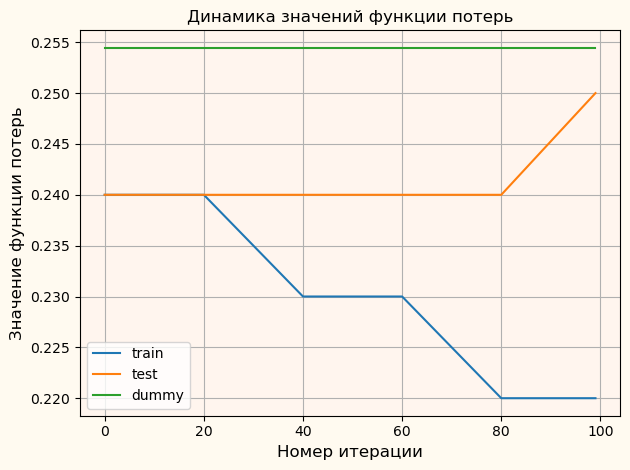

In [73]:
rmse_dummy_1 = [rmse_dummy for i in yy_test]

fig, ax = plt.subplots()

ax.plot(xx, yy_train, label='train')
ax.plot(xx, yy_test, label='test')
ax.plot(xx, rmse_dummy_1, label='dummy')

ax.set_xlabel('Номер итерации', fontsize=12)
ax.set_ylabel('Значение функции потерь', fontsize=12)

fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

ax.set_title('Динамика значений функции потерь')

ax.grid(True)
fig.tight_layout()

ax.legend()
plt.show()

Значений лучше, чему у Dummy

# Тестирование модели

Необходимо протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Напишем функцию, которая по тексту выводит набор изображений

In [74]:
def picture_find(text):
    text_lemmatized = clean_text_v1(text)
    if kinder_check(text_lemmatized) == 1:
        print('Bad query! Laws of your country does not let us to show you results.')
    else:

        text_tensor = np.array([nlp(clean_text_v1(text)).vector])

        X = np.concatenate((test_image_embeddings, np.tile(text_tensor, (test_image_embeddings.shape[0], 1))), axis=1)

        X_test_r = torch.FloatTensor(X)

        with torch.no_grad():
            predictions = best_net(X_test_r).flatten().numpy()

        #А здесь ранжирвоание и вывод на экран:

        df = pd.concat((test_queries, pd.Series(predictions, name='pred')), axis=1)
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))
        print('-' * 20, text, '-' * 20)


        fig = plt.figure(figsize=(15,5))
        for i in range(5):
            fig.add_subplot(1, 5, i+1, title=round(top_score[i], 2))
            image_path = os.path.join(os.path.join(DATA_PATH, 'test_images/'), top[i])
            image = Image.open(image_path)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

In [75]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe= test_images,
    directory=os.path.join(DATA_PATH, 'test_images/'),
    x_col='image',
    y_col='total_score',
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    seed=12345,
    shuffle=False
)

Found 100 validated image filenames.


Создадим векторы:

In [76]:
backbone = ResNet50(
input_shape=(224, 224, 3),
weights='imagenet',
include_top=False)


model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [77]:
test_image_embeddings = model.predict(test_gen_flow)
test_image_embeddings.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 751ms/step


(100, 2048)

-------------------- Two women are wearing lavender scarves an their heads . --------------------


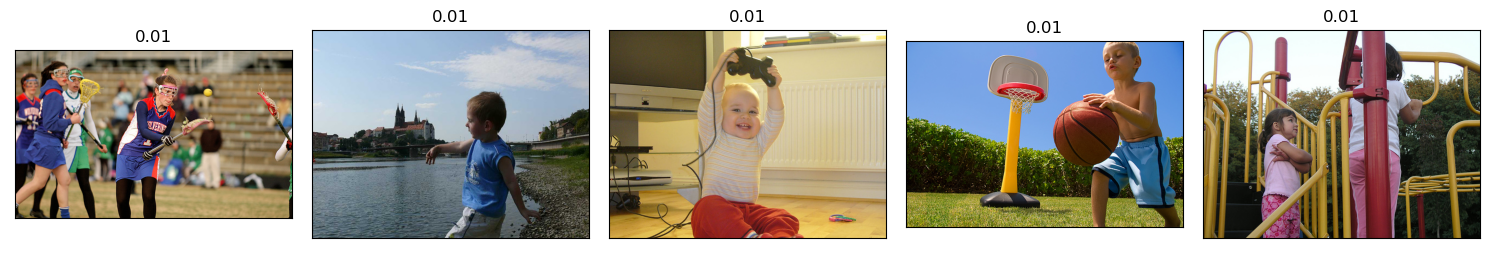

Bad query! Laws of your country does not let us to show you results.
-------------------- A man and a woman are sitting on a bench outside a wooden building . --------------------


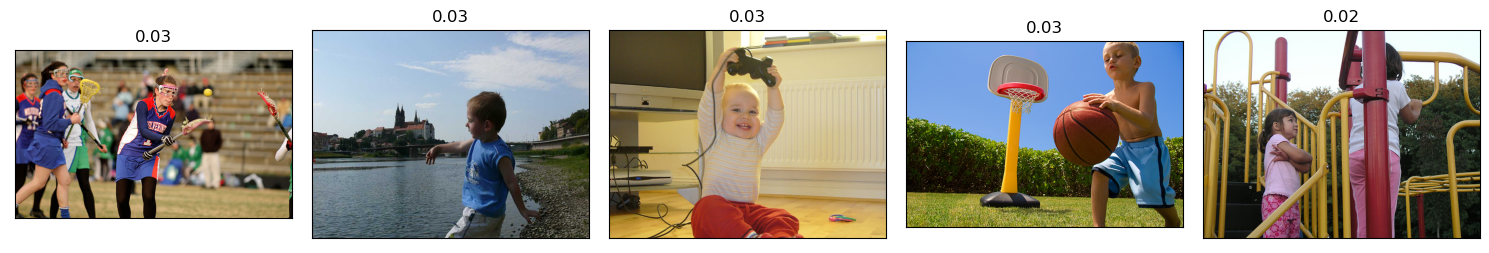

-------------------- a black and grey dog catches a tennis ball at the beach --------------------


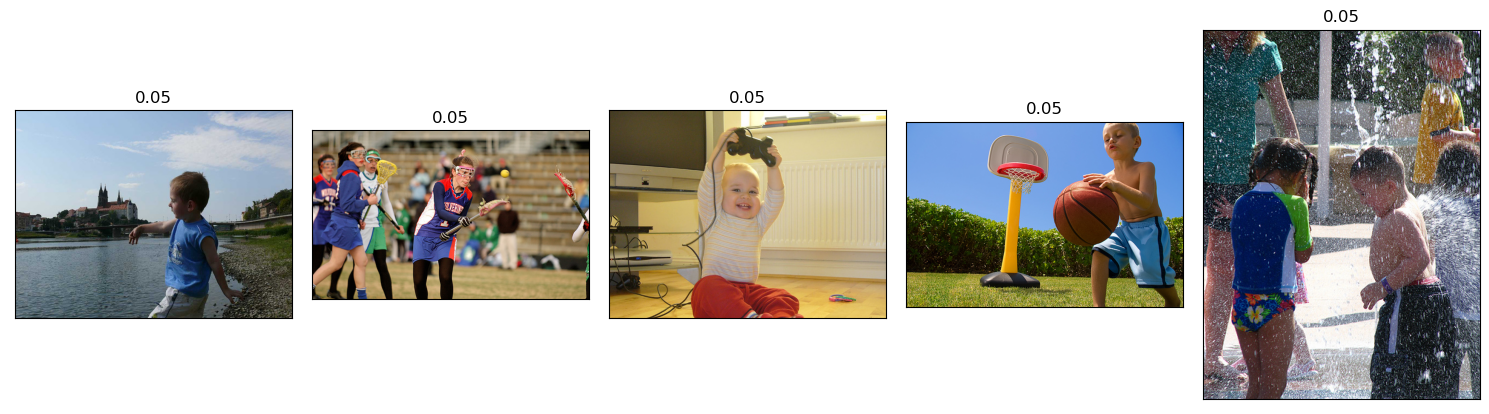

Bad query! Laws of your country does not let us to show you results.
Bad query! Laws of your country does not let us to show you results.
Bad query! Laws of your country does not let us to show you results.
-------------------- A dog fetching a stick . --------------------


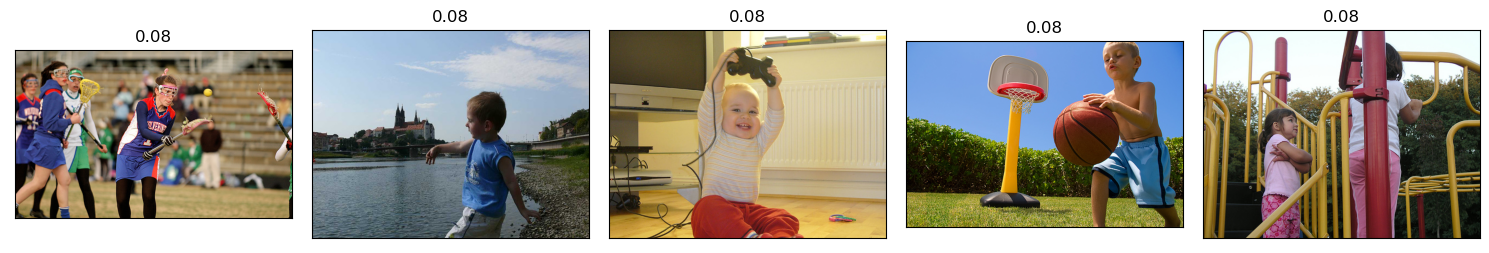

-------------------- The tennis player in the blue shirt is holding his racquet up in the air . --------------------


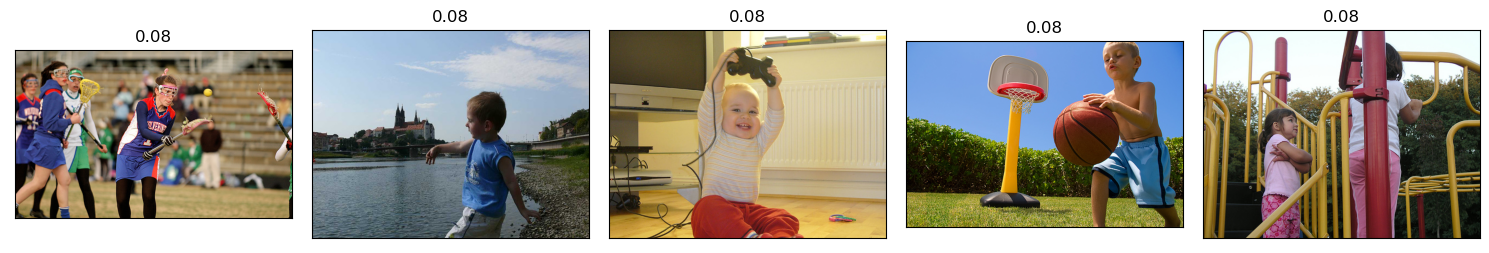

-------------------- little dog is jumping up to catch a red ball in its mouth . --------------------


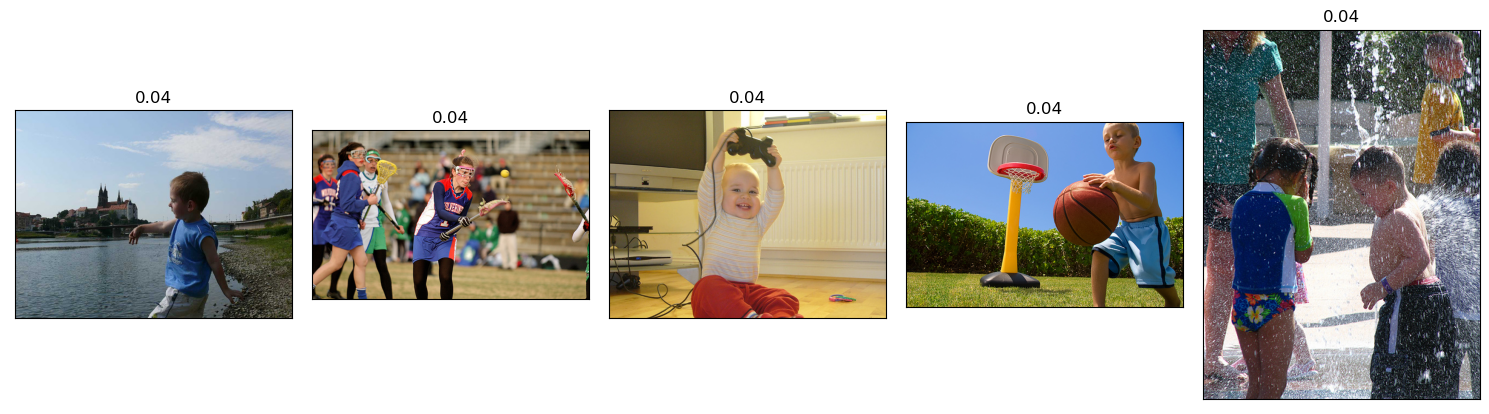

In [78]:
ten_queries = test_queries.sample(10)
ten_text = list(ten_queries.query_text)
for text in ten_text:
    picture_find(text)

# Вывод

После тестирования нескольких моделей были сделаны выводы, что наилучшим образом подходит нейросеть

## Проделанная работа

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска